# Bharat Intern

### Task 2:- Movie Recommendations :
**Objective:-** Build a movie recommendation system using collaborative filtering and machine learning techniques in Python.    
**Dataset:-** https://www.kaggle.com/datasets/mejbahahammad/movielens-20m-dataset

In [1]:
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime

from datetime import datetime

now = datetime.now()

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
%matplotlib inline


from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error


import tensorflow as tf
import keras
from keras.layers import Reshape


from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras.layers import Embedding, Flatten, dot
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Bidirectional

# Load the data

In [2]:
ratingDF = pd.read_csv('/Users/asaifali/Downloads/archive-8/ratings.csv')

# Convert fields into appropriate data types

In [3]:
ratingDF.userId = ratingDF.userId.astype(str).astype(int)
ratingDF.movieId = ratingDF.movieId.astype(str).astype(int)
ratingDF.rating = ratingDF.rating.astype(str).astype(float)
ratingDF.timestamp = ratingDF.timestamp.apply(lambda x: now.strftime("%m/%d/%Y, %H:%M:%S"))

In [4]:
n_users = ratingDF.userId.unique().shape[0]
n_movies = ratingDF.movieId.unique().shape[0]
n_ratings = len(ratingDF)
avg_ratings_per_user = n_ratings/n_users

In [5]:
print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

Number of unique users:  138493
Number of unique movies:  26744
Number of total ratings:  20000263
Average number of ratings per user:  144.4135299257002


In [6]:
movieIndex = ratingDF.groupby("movieId").count().sort_values(by= \
"rating",ascending=False)[0:1000].index
ratingDFX2 = ratingDF[ratingDF.movieId.isin(movieIndex)]
ratingDFX2.count()

userId       12840344
movieId      12840344
rating       12840344
timestamp    12840344
dtype: int64

In [7]:
userIndex = ratingDFX2.groupby("userId").count().sort_values(by= \
"rating",ascending=False).sample(n=1000, random_state=2018).index
ratingDFX3 = ratingDFX2[ratingDFX2.userId.isin(userIndex)]
ratingDFX3.count()

userId       90213
movieId      90213
rating       90213
timestamp    90213
dtype: int64

Let’s also reindex movieID and userID to a range of 1 to 1,000 for our
reduced dataset:

In [8]:
movies = ratingDFX3.movieId.unique()
moviesDF = pd.DataFrame(data=movies,columns=['originalMovieId'])
moviesDF['newMovieId'] = moviesDF.index+1

In [9]:
users = ratingDFX3.userId.unique()
usersDF = pd.DataFrame(data=users,columns=['originalUserId'])
usersDF['newUserId'] = usersDF.index+1

In [10]:
ratingDFX3 = ratingDFX3.merge(moviesDF,left_on='movieId', \
right_on='originalMovieId')
ratingDFX3.drop(labels='originalMovieId', axis=1, inplace=True)
ratingDFX3 = ratingDFX3.merge(usersDF,left_on='userId', \
right_on='originalUserId')
ratingDFX3.drop(labels='originalUserId', axis=1, inplace=True)

Let’s calculate the number of unique users, unique movies, total ratings, and
average number of ratings per user for our reduced dataset:

In [11]:
n_users = ratingDFX3.userId.unique().shape[0]
n_movies = ratingDFX3.movieId.unique().shape[0]
n_ratings = len(ratingDFX3)
avg_ratings_per_user = n_ratings/n_users

In [12]:
print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

Number of unique users:  1000
Number of unique movies:  1000
Number of total ratings:  90213
Average number of ratings per user:  90.213


Let’s generate a test set and a validation set from this reduced dataset so
that each holdout set is 5% of the reduced dataset:

In [13]:
X_train, X_test = train_test_split(ratingDFX3,
test_size=0.10, shuffle=True, random_state=2018)
X_validation, X_test = train_test_split(X_test,
test_size=0.50, shuffle=True, random_state=2018)

In [14]:
print('Shape of train set:', X_train.shape)
print('Shape of validation set:',X_validation.shape)
print('Shape of test set: ',X_test.shape)

Shape of train set: (81191, 6)
Shape of validation set: (4511, 6)
Shape of test set:  (4511, 6)


In [15]:
print('Size of train set:', X_train.size)
print('Size of validation set:',X_validation.size)
print('Size of test set: ',X_test.size)

Size of train set: 487146
Size of validation set: 27066
Size of test set:  27066


## Define the Cost Function: Mean Squared Error

In [16]:
# Generate ratings matrix for train
ratings_train = np.zeros((n_users, n_movies))
for row in X_train.itertuples():
    ratings_train[row[6]-1, row[5]-1] = row[3]

In [17]:
sparsity = float(len(ratings_train.nonzero()[0]))
sparsity /= (ratings_train.shape[0] * ratings_train.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 8.12%


In [18]:
# Generate ratings matrix for validation
ratings_validation = np.zeros((n_users, n_movies))
for row in X_validation.itertuples():
    ratings_validation[row[6]-1, row[5]-1] = row[3]

In [19]:
# Generate ratings matrix for test
ratings_test = np.zeros((n_users, n_movies))
for row in X_test.itertuples():
    ratings_test[row[6]-1, row[5]-1] = row[3]

# Perform Baseline Experiments

In [20]:
actual_validation = ratings_validation[ratings_validation.nonzero()].flatten()

In [21]:
pred_validation = np.zeros((len(X_validation),1))
pred_validation[pred_validation==0] = 3.5
pred_validation

array([[3.5],
       [3.5],
       [3.5],
       ...,
       [3.5],
       [3.5],
       [3.5]])

In [22]:
print("Mean  Squared Error is : ", mean_squared_error(pred_validation, actual_validation))

Mean  Squared Error is :  1.055420084238528


In [23]:
ratings_validation_prediction = np.zeros((n_users, n_movies))
i = 0
for row in ratings_train:
    ratings_validation_prediction[i][ratings_validation_prediction[i]==0] = np.mean(row[row>0])
    i += 1

In [24]:
pred_validation = ratings_validation_prediction  [ratings_validation.nonzero()].flatten()
user_average = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using user average:', user_average)

Mean squared error using user average: 0.9090717929472647


In [25]:
ratings_validation_prediction = np.zeros((n_users, n_movies)).T
i = 0
for row in ratings_train.T:
    ratings_validation_prediction[i][ratings_validation_prediction[i]==0] = np.mean(row[row>0])
    i += 1

In [26]:
ratings_validation_prediction = ratings_validation_prediction.T
pred_validation = ratings_validation_prediction[ratings_validation.nonzero()].flatten()
movie_average = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using movie average:', movie_average)

Mean squared error using movie average: 0.9136057106858655


In [27]:
from keras.layers import GRU, Bidirectional, concatenate, Dense, Input, BatchNormalization, Dropout

# Adjust the number of units in the GRU layer
n_latent_factors = 1
gru_units = 64
sequence_length = 10  # Placeholder value, please replace with your sequence length
user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, output_dim=n_latent_factors,
name='user_embedding')(user_input)

# Create an input for the sequences of movie embeddings
movie_sequence_input = Input(shape=(sequence_length, n_latent_factors), name='movie_sequence')

# Create a Bidirectional GRU layer
movie_gru = Bidirectional(GRU(gru_units))(movie_sequence_input)

# Concatenate the user and movie GRU outputs
user_vec = Flatten(name='flatten_users')(user_embedding)
concatenated = concatenate([movie_gru, user_vec])

# Add batch normalization
concatenated = BatchNormalization()(concatenated)

# Add dropout
concatenated = Dropout(0.2)(concatenated)

# Add a fully connected layer
concatenated = Dense(64, activation='relu')(concatenated)

# Add batch normalization
concatenated = BatchNormalization()(concatenated)

# Add dropout
concatenated = Dropout(0.2)(concatenated)

# Add the output layer
output = Dense(1, activation='linear')(concatenated)

# Create the model
model_2 = Model(inputs=[user_input, movie_sequence_input], outputs=output)

# Compile the model
model_2.compile(optimizer='adam', loss='mean_squared_error')


2023-11-21 20:02:44.532085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-21 20:02:44.533832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-21 20:02:44.534989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [28]:
n_latent_factors = 1
user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, output_dim=n_latent_factors,
name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)
movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1,
output_dim=n_latent_factors,
name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)
product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [29]:
history = model_2.fit(x=[X_train.newUserId, X_train.newMovieId],
                    y=X_train.rating, epochs=100,
                    validation_data=([X_validation.newUserId,
                                      X_validation.newMovieId], X_validation.rating),
                    verbose=1)

Epoch 1/100


2023-11-21 20:02:44.780937: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-21 20:02:44.931514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-21 20:02:44.932284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-21 20:02:44.932862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG IN

2518/2538 [============================>.] - ETA: 0s - loss: 2.0819

2023-11-21 20:02:55.016728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-21 20:02:55.018515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-21 20:02:55.019885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2538/2538 [==============================] - 11s 3ms/step - loss: 2.0749 - val_loss: 0.9393
Epoch 2/100
2538/2538 [==============================] - 8s 3ms/step - loss: 1.0637 - val_loss: 0.9141
Epoch 3/100
2538/2538 [==============================] - 7s 3ms/step - loss: 0.9931 - val_loss: 0.9135
Epoch 4/100
2538/2538 [==============================] - 6s 2ms/step - loss: 0.9681 - val_loss: 0.9192
Epoch 5/100
2538/2538 [==============================] - 7s 3ms/step - loss: 0.9505 - val_loss: 0.9272
Epoch 6/100
2538/2538 [==============================] - 7s 3ms/step - loss: 0.9468 - val_loss: 0.9092
Epoch 7/100
2538/2538 [==============================] - 6s 2ms/step - loss: 0.9388 - val_loss: 0.9090
Epoch 8/100
2538/2538 [==============================] - 7s 3ms/step - loss: 0.9390 - val_loss: 0.9098
Epoch 9/100
2538/2538 [==============================] - 7s 3ms/step - loss: 0.9338 - val_loss: 0.9197
Epoch 10/100
2538/2538 [==============================] - 7s 3ms/step - loss: 0.9312

Minimum RMSE:  0.9483065205209972


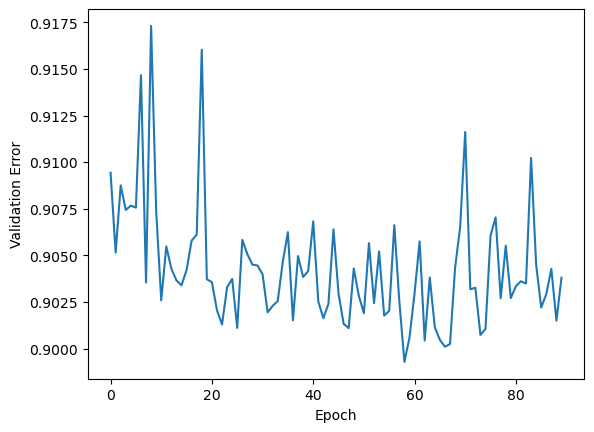

In [31]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum RMSE: ', np.sqrt(min(history.history['val_loss'])))